### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

### Import Dataset

In [5]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [6]:
dataset = datasets.ImageFolder(r"D:\Datasets\Plant_leave_diseases_dataset_with_augmentation", transform=transform)

In [7]:
dataset

Dataset ImageFolder
    Number of datapoints: 61486
    Root location: D:\Datasets\Plant_leave_diseases_dataset_with_augmentation
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [8]:
indices = list(range(len(dataset)))

In [9]:
split = int(np.floor(0.85 * len(dataset)))  # train_size

In [10]:
validation = int(np.floor(0.70 * split))  # validation

In [11]:
print(0, validation, split, len(dataset))

0 36584 52263 61486


In [12]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :36584
length of validation size :15679
length of test size :24902


In [13]:
np.random.shuffle(indices)

### Split into Train and Test

In [14]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [15]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [16]:
targets_size = len(dataset.class_to_idx)

### Model

<b>Convolution Aithmetic Equation : </b>(W - F + 2P) / S + 1 <br>
W = Input Size<br>
F = Filter Size<br>
P = Padding Size<br>
S = Stride <br>

### Transfer Learning

In [17]:
# model = models.vgg16(pretrained=True)

In [18]:
# for params in model.parameters():
#     params.requires_grad = False

In [19]:
# model

In [20]:
# n_features = model.classifier[0].in_features
# n_features

In [21]:
# model.classifier = nn.Sequential(
#     nn.Linear(n_features, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(1024, targets_size),
# )

In [22]:
# model

### Original Modeling

In [23]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [25]:
device = "cpu"

In [26]:
model = CNN(targets_size)

In [27]:
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [28]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

In [29]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

### Batch Gradient Descent

In [30]:
def batch_gd(model, criterion, train_loader, test_laoder, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [31]:
device = "cpu"

In [33]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [34]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 5
)

Epoch : 1/5 Train_loss:2.283 Test_loss:1.580 Duration:5:51:25.500738
Epoch : 2/5 Train_loss:1.292 Test_loss:1.221 Duration:6:17:02.705244
Epoch : 3/5 Train_loss:1.039 Test_loss:1.019 Duration:5:41:36.348879
Epoch : 4/5 Train_loss:0.845 Test_loss:0.884 Duration:5:40:48.593094
Epoch : 5/5 Train_loss:0.718 Test_loss:0.741 Duration:6:02:05.397634


### Save the Model

In [35]:
 torch.save(model.state_dict() , 'plant_disease_model_1.pt')

### Load Model

In [53]:
targets_size = 39
model = CNN(targets_size)
model.load_state_dict(torch.load("plant_disease_model_1_latest.pt"))
model.eval()

C:\Users\Dubai Computers\AppData\Local\Temp\ipykernel_5636\2475572165.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("plant_disease_mod

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [56]:
#%matplotlib notebook

### Plot the loss

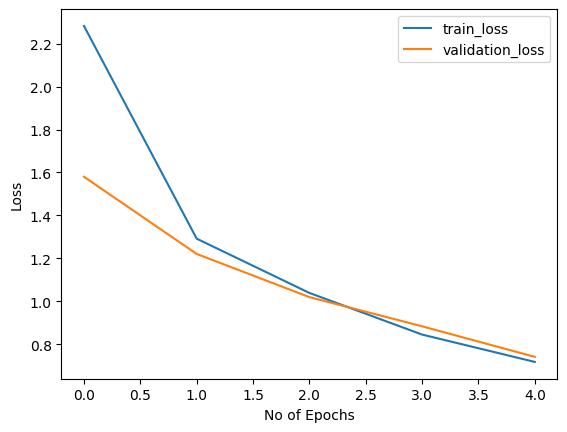

In [83]:
%matplotlib inline
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [41]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [42]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

In [43]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9378416794226985
Test Accuracy : 0.9371137373956413
Validation Accuracy : 0.9359015243319089


### Single Image Prediction

In [58]:
transform_index_to_disease = dataset.class_to_idx

In [46]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)  # reverse the index

In [67]:
transform_index_to_disease

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Background_without_leaves': 4,
 'Blueberry___healthy': 5,
 'Cherry___Powdery_mildew': 6,
 'Cherry___healthy': 7,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8,
 'Corn___Common_rust': 9,
 'Corn___Northern_Leaf_Blight': 10,
 'Corn___healthy': 11,
 'Grape___Black_rot': 12,
 'Grape___Esca_(Black_Measles)': 13,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14,
 'Grape___healthy': 15,
 'Orange___Haunglongbing_(Citrus_greening)': 16,
 'Peach___Bacterial_spot': 17,
 'Peach___healthy': 18,
 'Pepper,_bell___Bacterial_spot': 19,
 'Pepper,_bell___healthy': 20,
 'Potato___Early_blight': 21,
 'Potato___Late_blight': 22,
 'Potato___healthy': 23,
 'Raspberry___healthy': 24,
 'Soybean___healthy': 25,
 'Squash___Powdery_mildew': 26,
 'Strawberry___Leaf_scorch': 27,
 'Strawberry___healthy': 28,
 'Tomato___Bacterial_spot': 29,
 'Tomato___Early_blight': 30,
 'Tomato___Late_blight': 31,
 'Tomato__

In [65]:
data = pd.read_csv("disease_info.csv", encoding="cp1252")

In [66]:
from PIL import Image
import torchvision.transforms.functional as TF

In [60]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred_csv = data["disease_name"][index]
    print(pred_csv)

In [80]:
single_prediction(r"D:\Datasets\test images/apple_healthy.JPG")

Original :  test images/apple_healthy
Apple : Healthy


### Wrong Prediction

In [12]:
single_prediction("test_images/apple_black_rot.JPG")

Original :  apple_black_rot
Pepper bell : Healthy


In [13]:
single_prediction("test_images/apple_healthy.JPG")

Original :  apple_healthy
Apple : Healthy


In [14]:
single_prediction("test_images/background_without_leaves.jpg")

Original :  background_without_leaves
Background Without Leaves


In [15]:
single_prediction("test_images/blueberry_healthy.JPG")

Original :  blueberry_healthy
Blueberry : Healthy


In [16]:
single_prediction("test_images/cherry_healthy.JPG")

Original :  cherry_healthy
Cherry : Healthy


In [17]:
single_prediction("test_images/cherry_powdery_mildew.JPG")

Original :  cherry_powdery_mildew
Cherry : Powdery Mildew


In [18]:
single_prediction("test_images/corn_cercospora_leaf.JPG")

Original :  corn_cercospora_leaf
Corn : Cercospora Leaf Spot | Gray Leaf Spot


In [19]:
single_prediction("test_images/corn_common_rust.JPG")

Original :  corn_common_rust
Corn : Common Rust


In [20]:
single_prediction("test_images/corn_healthy.jpg")

Original :  corn_healthy
Corn : Healthy


In [21]:
single_prediction("test_images/corn_northen_leaf_blight.JPG")

Original :  corn_northen_leaf_blight
Corn : Northern Leaf Blight


In [22]:
single_prediction("test_images/grape_black_rot.JPG")

Original :  grape_black_rot
Grape : Black Rot


In [23]:
single_prediction("test_images/grape_healthy.JPG")

Original :  grape_healthy
Grape : Healthy


In [24]:
single_prediction("test_images/grape_leaf_blight.JPG")

Original :  grape_leaf_blight
Grape : Leaf Blight | Isariopsis Leaf Spot


In [25]:
single_prediction("test_images/orange_haunglongbing.JPG")

Original :  orange_haunglongbing
Orange : Haunglongbing | Citrus Greening


In [26]:
single_prediction("test_images/peach_bacterial_spot.JPG")

Original :  peach_bacterial_spot
Peach : Bacterial Spot


In [27]:
single_prediction("test_images/peach_healthy.JPG")

Original :  peach_healthy
Peach : Healthy


In [28]:
single_prediction("test_images/pepper_bacterial_spot.JPG")

Original :  pepper_bacterial_spot
Pepper bell : Healthy


In [29]:
single_prediction("test_images/pepper_bell_healthy.JPG")

Original :  pepper_bell_healthy
Pepper bell : Healthy


In [30]:
single_prediction("test_images/potato_early_blight.JPG")

Original :  potato_early_blight
Potato : Early Blight


In [31]:
single_prediction("test_images/potato_healthy.JPG")

Original :  potato_healthy
Potato : Healthy


In [32]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Potato : Late Blight


In [33]:
single_prediction("test_images/raspberry_healthy.JPG")

Original :  raspberry_healthy
Raspberry : Healthy


In [34]:
single_prediction("test_images/soyaben healthy.JPG")

Original :  soyaben healthy
Soybean : Healthy


In [35]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Potato : Late Blight


In [36]:
single_prediction("test_images/squash_powdery_mildew.JPG")

Original :  squash_powdery_mildew
Squash : Powdery Mildew


In [37]:
single_prediction("test_images/starwberry_healthy.JPG")

Original :  starwberry_healthy
Strawberry : Healthy


In [38]:
single_prediction("test_images/starwberry_leaf_scorch.JPG")

Original :  starwberry_leaf_scorch
Strawberry : Leaf Scorch


In [39]:
single_prediction("test_images/tomato_bacterial_spot.JPG")

Original :  tomato_bacterial_spot
Tomato : Early Blight


In [40]:
single_prediction("test_images/tomato_early_blight.JPG")

Original :  tomato_early_blight
Tomato : Early Blight


In [41]:
single_prediction("test_images/tomato_healthy.JPG")

Original :  tomato_healthy
Tomato : Healthy


In [42]:
single_prediction("test_images/tomato_late_blight.JPG")

Original :  tomato_late_blight
Tomato : Late Blight


In [43]:
single_prediction("test_images/tomato_leaf_mold.JPG")

Original :  tomato_leaf_mold
Tomato : Leaf Mold


In [44]:
single_prediction("test_images/tomato_mosaic_virus.JPG")

Original :  tomato_mosaic_virus
Tomato : Mosaic Virus


In [45]:
single_prediction("test_images/tomato_septoria_leaf_spot.JPG")

Original :  tomato_septoria_leaf_spot
Tomato : Septoria Leaf Spot


In [46]:
single_prediction("test_images/tomato_spider_mites_two_spotted_spider_mites.JPG")

Original :  tomato_spider_mites_two_spotted_spider_mites
Tomato : Spider Mites | Two-Spotted Spider Mite


In [47]:
single_prediction("test_images/tomato_target_spot.JPG")

Original :  tomato_target_spot
Tomato : Target Spot


In [48]:
single_prediction("test_images/tomato_yellow_leaf_curl_virus.JPG")

Original :  tomato_yellow_leaf_curl_virus
Tomato : Yellow Leaf Curl Virus


In [85]:
 torch.save(model.state_dict() , 'plant_disease_model_Entire.pt')